## Also, I realize I was indeed doing it wrong before. I was splitting the ED and ES frames into their own respective horizontal cuts than computing the strain on the arbitrary cuts I am making on the ED and ES frames. I need to

## 1. Slice ED Label<br>2. Warp the individual slices<br>3. Calculate Strain on $Slice_i$ and $Slice_{i+1}$

## We test out if we can get more accurately slicing of the LV into `N` slices to get local strain analyses by using `get2dpucks` function to do a little more complicated slicing of the LV

In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_10_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.11it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()

elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
def rmse(x, y):
    ''' return root mean square error difference between the two values passed in'''
    return np.sqrt((x - y) ** 2)

def strain_value(l_0, l_i):
    '''
    inputs: l_0, l_i -- original length and new length at some time point, respectively
    output: e -- strain value (positive for elongation, negative for compressing/shortening) as a percentage (e.g. output 0.155 == 15.5 %)
    
    examples: 
        l_i = 10
        l_0 = 5
        e == (10 - 5) / 5 = 1, factor of lengthening relative to original value
        
        l_i = 5
        l_0 = 5
        e == (5 - 5) / 5 = 0, no strain
    '''
    return (l_i - l_0) / l_0

def give_boundary(x):
    '''
    input: 
        x (112, 112) one-hot encoded lv mask/segmentation
        unique values (0,1)
        has to be numpy ndarray on cpu mem
    output: 
        y (112, 112) black and white picture of boundary of lv
        unique vals (0,1)
    '''
    foo = np.uint8(x * 255)
    ret, thresh = cv.threshold(foo, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    blank = np.zeros((112,112))
    cv.drawContours(blank, contours, -1, (255,255,255), 1)
    
    # return boundary image with unique values of (0,1)
    blank = blank / 255
    
    return blank

def boundaries_to_strain(before, after):
    '''
    input:
        before (112, 112) boundary of lv
        after (112, 112) boundary of lv
        expect unique values of (0,1)
        
    output: 
        y - floating point number representing strain value, left as a decimal, NOT multiplied by 100
    '''
    # # make sure values in image are only 0 and 1
    # check_unique_vals = np.unique(before)
    # if check_unique_vals[0] == 0 and check_unique_vals[1] == 255:
    #     before = before / 255
    # check_unique_vals = np.unique(after)
    # if check_unique_vals[0] == 0 and check_unique_vals[1] == 255:
    #     after = after / 255
        
    # cut basal plane out
    before = cut_basal_plane_out(before)
    after = cut_basal_plane_out(after)
    
    # count lv pixels
    l_0 = np.count_nonzero(before == 1)
    l_i = np.count_nonzero(after == 1)
    
    return strain_value(l_0, l_i)
    
def images_to_strain(ed_frame, es_frame):
    '''
    input:
        ed_frame (112, 112)
        es_frame (112, 112)
        
        expect vals to be one-hot encoded (1's for lv, 0's for not lv)
    output:
        x - floating point number
        strain value (some decimal, should be negative)
    '''
    # get boundaries, then cut basal plane out
    ed_bound = cut_basal_plane_out(give_boundary(ed_frame))
    es_bound = cut_basal_plane_out(give_boundary(es_frame))
    # compute strain and return
    return boundaries_to_strain(ed_bound, es_bound)

In [5]:
def blot_out_given_rect(rectangle_corners, I, replace_val = 0):
    '''
    input:
        rectangle_corners - shape (2,2)
        I - shape (112, 112) 
        
    output:
        I_copy -- deepcopy of original image I with the defined rectangle section given zeroed out in the image
    '''
    
     # i = row, j = col, we're thinking in ij/row col instead of xy
    if rectangle_corners[0][0] < rectangle_corners[1][0]:
        i_start = int(rectangle_corners[0][0])
        i_end = int(rectangle_corners[1][0])
    else:
        i_end = int(rectangle_corners[0][0])
        i_start = int(rectangle_corners[1][0])
        
    if rectangle_corners[1][1] < rectangle_corners[0][1]:
        j_start = int(rectangle_corners[1][1])
        j_end = int(rectangle_corners[0][1])
    else:
        j_end = int(rectangle_corners[1][1])
        j_start = int(rectangle_corners[0][1])
        
    # make copy and alter then return
    import copy 
    I_copy = copy.deepcopy(I)
    
    # zero out everything at and below the highest of the two index points (i_start)
    I_copy[i_start : I.shape[0], 0 : I.shape[1]] = replace_val
    
    return I_copy

In [6]:
def blank_with_rect(rectangle_corners, I, replace_val=127):
    '''
    input:
        rectangle_corners - shape (2, 2)
    output:
        empty image with the rectangle as defined blotted out with values of 127 -- shape (112, 112)
    '''
    I_rect = np.zeros(I.shape)
    I_rect = blot_out_given_rect(rectangle_corners, I_rect, replace_val=replace_val)
    return I_rect

In [7]:
def plot_rectangle(rectangle_corners, I=None, show_applied=False):
    '''
    input:
        rectangle_corners - shape (2,2)
        Well, technically rectangle corners could even have shape of (4, 2)
    
    plot a rectangle based on the coords given (in format of the skimage functions that get the corner pixels coords)
    also if an image is given, plot the rectangle on top of it
    '''
   
    # plot the rectangle
    I_rect = blank_with_rect(rectangle_corners, I)
    
    # plot the original image if given
    plt.figure(figsize=(10,5))
    if I is not None:
        # assuming I has unique values (0,1)
        plt.imshow(I * 255, cmap='gray', zorder=1)
        plt.imshow(I_rect, cmap='gray', zorder=2, alpha=0.5)
        # plt.colorbar()
    else:
        plt.imshow(I_rect, cmap='gray')
    
    plt.show()
    
    # show another figure of using the shown rectangle to zero out original image if asked
    if show_applied:
        plt.figure(figsize=(10,5))
        plt.imshow(blot_out_given_rect(rectangle_corners, I), cmap='gray')
        plt.show()

In [8]:
def vizualize_corner_pixels_detected(I, show_plot=True, return_vars=False):
    '''
    input: I (112, 112), unique vals of 0,1
    output (if requested):
        coords - numpy ndarray
        coords_subpix - nump ndarray
            shapes of 2 objects above may vary...
    
    Prints the matplotlib figure with the corner pixels detected attached to the image
    
    '''
    from skimage.feature import corner_harris, corner_subpix, corner_peaks

    # make sure values in image are only 0 and 1
    check_unique_vals = np.unique(I)
    if check_unique_vals[0] == 0 and check_unique_vals[1] == 255:
        I = I / 255
    elif check_unique_vals[0] == 0 and check_unique_vals[1] != 1:
        print('incorrect values in Image')
        return

    coords = corner_peaks(corner_harris(I), min_distance=5, threshold_rel=0.02)
    coords_subpix = corner_subpix(I, coords, window_size=13)

    if show_plot:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(I, cmap=plt.cm.gray)
        ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
                linestyle='None', markersize=6)
        ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
        plt.show()
    
    # return quantities if requested
    if return_vars:
        return coords, coords_subpix

In [9]:
def get_rectangle_corners(I):
    '''
    input:
        I - shape (112, 112)
    output:
        rectange_corners - shape (2,2)
    '''
    from skimage.feature import corner_harris, corner_subpix, corner_peaks

    # get corner pixels to form rectangle from
    coords = corner_peaks(corner_harris(I), min_distance=5, threshold_rel=0.02)    
    
    # descending order sort all possible values along axis=0 for sorting by i / row index
    coords[::-1].sort(axis=0)
    
    rectangle_corners = coords[0:2]

    return rectangle_corners

In [10]:
def cut_basal_plane_out(I):
    '''
    input: I (112, 112) expected to have unique values of (0,1)...1 for lv, 0 for not lv
    output: I_new (112, 112) with unique values of (0,1)... 1 for lv, 0 for not lv...this has the basal plane removed
    
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
    
    When choosing which 2 points to create a rough rectangle to zero out the bottom mitral valve / basal plane boundary
    we will go with this ordering of points to use:
    1. Both points from corner_subpix
    2. One point from corner_subpix, one point from corner_peaks
    3. Both points from corner_peaks
    
    If we can't get two points at the area of the basal plane from any of the three situations described above, we are out of luck. 
    We will have to do something else, but this won't work then. 
    '''  
    # # make sure values in image are only 0 and 1
    # check_unique_vals = np.unique(I)
    # if check_unique_vals[0] == 0 and check_unique_vals[1] == 255:
    #     I = I / 255
    # elif check_unique_vals[0] == 0 and check_unique_vals[1] != 1:
    #     print('incorrect values in Image')
    #     return
    
    rectangle_corners = get_rectangle_corners(I)
    return blot_out_given_rect(rectangle_corners, I)

In [11]:
%matplotlib widget

# taken from stough's dip vis_utils.py
def vis_pair(I, J, figsize = (8,3), shared = True, 
             first_title = 'Original', second_title = 'New',
             show_ticks = True, **kwargs):
    '''
    vis_pair(I, J, figsize = (8,3), shared = True, first_title = 'Original', second_title = 'New'):
    produce a plot of images I and J together. By default takes care of sharing axes to provide
    a little 1x2 plot without all the coding.
    '''
    f, ax = plt.subplots(1,2, figsize=figsize, sharex = shared, sharey = shared)
    ax[0].imshow(I, **kwargs)
    ax[0].set_title(first_title)
    ax[1].imshow(J, **kwargs)
    ax[1].set_title(second_title)
    
    if not show_ticks:
        [a.axes.get_xaxis().set_visible(False) for a in ax];
        [a.axes.get_yaxis().set_visible(False) for a in ax];
    
    plt.tight_layout()

In [12]:
def get_seg_and_warp_data(model, test_dataset, test_pat_index):
    '''
    input: 
         model, dataset, and video index in dataset
    output:
        segmentation and motion tracking info on a specified video
        delta_ed_es = index difference between the ed and es clip
        returned seg/mot information is for a 32 frame clip where ed is at index 0
        clip_index - index of clip 
    '''
    ########################### Helper functions ###########################
    # goes thru a video and annotates where we can start clips given video length, clip length, etc.
    def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
        assert es_index - ed_index > 0, "not a ED to ES clip pair"
        possible_shift = clip_length - (es_index - ed_index)
        allowed_right = video_length - es_index
        if allowed_right < possible_shift:
            return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
        if possible_shift < 0:
            return np.array([ed_index])
        elif ed_index < possible_shift:
            return np.arange(ed_index + 1)
        else:
            return np.arange(ed_index - possible_shift + 1, ed_index + 1)
        
    def generate_2dmotion_field_PLAY(x, offset):
        # Qin's code for joint_motion_seg learning works fine on our purpose too
        # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
        x_shape = x.shape
        # print(f'x_shape: {x_shape}')

        grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)

        # this should just be moving the vars to gpu mem and doing some data type conversion to some
        # floating point precision
        grid_w = grid_w.cuda().float()
        grid_h = grid_h.cuda().float()

        grid_w = nn.Parameter(grid_w, requires_grad=False)
        grid_h = nn.Parameter(grid_h, requires_grad=False)

        # OLD 
        # offset_h, offset_w = torch.split(offset, 1, 1)
        # NEW , TESTING
        offset_h, offset_w = torch.split(offset, 1)

        offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
        offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

        offset_w = grid_w + offset_w
        offset_h = grid_h + offset_h

        offsets = torch.stack((offset_h, offset_w), 3)
        return offsets

    def categorical_dice(prediction, truth, k, epsilon=1e-5):
        """
            Compute the dice overlap between the predicted labels and truth
            Not a loss
        """
        # Dice overlap metric for label value k
        A = (prediction == k)
        B = (truth == k)
        return 2 * np.sum(A * B) / (np.sum(A) + np.sum(B) + epsilon)
    
    ########################################################################
    # initial grabbing of the data that we'll use
    video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]
    
    # get all possible start indices for 32 frame clip with ed/es in right order
    possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
    
    # for now, let's use the last clip from our set of all possible clips to use
    clip_index = len(possible_starts) - 1
    # print(f'clip_index: {clip_index}')

    # get the diff in frame len from ed to es
    delta_ed_es = es_index - ed_index
    
    # use model to segment frames
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]

    # grab whatever clip we want
    curr_clip_segmentations = segmentation_outputs[clip_index]
    curr_clip_motions = motion_outputs[clip_index]
    
    return curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label

In [13]:
def one_hot(I):
    '''
    input: I - shape (2, 112, 112)
    convert a raw segmentation output into a one_hot_encoded image
    '''
    import copy
    I_copy = copy.deepcopy(I)
    return np.argmax(I_copy, 0)

In [14]:
def get_dice(prediction, truth):
    '''
    assume both images are one_hot_encoded
    '''
    k = 1
    return categorical_dice(prediction, truth, k, epsilon=1e-5)

In [15]:
def warp_forward(I, motions, delta_ed_es, clip_index):
    '''
    input:
        I - shape (1, 2, 112, 112), not one-hot encoded, must be the raw model segmentation output
        motions - shape ()
        delta_ed_es - integer defining how many forward iterations to take (max 31)
                        we are only interested in warping to/from ED/ES
    output:
        I_1 - shape (1, 2, 112, 112), not one-hot encoded, raw ES image, if want one-hot encoded need to apply np.argmax
        
    for now, try to do things all on the cpu
    '''
    def generate_2dmotion_field_custom(x, offset):
        # Qin's code for joint_motion_seg learning works fine on our purpose too
        # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
        x_shape = x.shape
        # print(f'x_shape: {x_shape}')

        grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)

        # this should just be moving the vars to gpu mem and doing some data type conversion to some
        # floating point precision
        grid_w = grid_w.cuda().float()
        grid_h = grid_h.cuda().float()

        grid_w = nn.Parameter(grid_w, requires_grad=False)
        grid_h = nn.Parameter(grid_h, requires_grad=False)

        # OLD 
        # offset_h, offset_w = torch.split(offset, 1, 1)
        # NEW , TESTING
        offset_h, offset_w = torch.split(offset, 1)

        offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
        offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

        offset_w = grid_w + offset_w
        offset_h = grid_h + offset_h

        offsets = torch.stack((offset_h, offset_w), 3)
        return offsets
    
    # convert numpy ndarrays into tensor objects moved onto device
    flow_source = torch.from_numpy(I).to(device).float()
    motions = torch.from_numpy(motions).to(device).float()

    # warping FORWARD from ED -> ES
    # python range is [x, y), inclusive start and exclusive end
    for frame_index in range(31 - delta_ed_es - clip_index, 31 - clip_index + 1, 1):
        # grab forward motion
        forward_motion = motions[:2, frame_index,...]

        # # grab the ED seg out frame to warp
        # if frame_index == 0:
        #     # flow_source = np.array([curr_clip_segmentations[:, frame_index, ...]])
        #     flow_source = I
        #     print(f'type(flow_source): {type(flow_source)}')
        #     # flow_source = torch.from_numpy(flow_source).to(device).float()
        # else:
        #     pass # use previous next_label as flow_source, should be redefined at end of previous loop iter

        # convert to tensors and move to gpu with float dtype
        # forward_motion = torch.from_numpy(forward_motion).to(device).float()
        # generate motion field for forward motion
        motion_field = generate_2dmotion_field_custom(flow_source, forward_motion)
        # create frame i+1 relative to curr frame i 
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        # use i+1 frame as next loop iter's i frame
        flow_source = next_label

    flow_source = flow_source.cpu().detach().numpy()
    
    return flow_source

In [16]:
test_pat_index = 0

In [17]:
curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)

In [18]:
curr_clip_motions.shape

(4, 32, 112, 112)

In [20]:
curr_clip_segmentations.shape

(2, 32, 112, 112)

In [21]:
ed_raw_seg_out = curr_clip_segmentations[:,0,...]

In [22]:
ed_raw_seg_out.shape

(2, 112, 112)

In [23]:
z_, height, width = ed_raw_seg_out.shape

In [24]:
np.unique(ed_raw_seg_out)

array([-9.86601543, -9.85149574, -9.79540539, ..., 10.27981377,
       10.39611626, 10.40559196])

In [25]:
ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

In [26]:
ed_one_hot_seg_out.shape

(112, 112)

In [27]:
np.unique(ed_one_hot_seg_out)

array([0, 1])

In [28]:
get_dice(ed_one_hot_seg_out, ed_label)

tensor(0.9661)

In [29]:
foo = np.array([ed_raw_seg_out])

In [30]:
foo.shape

(1, 2, 112, 112)

In [31]:
I_warped = warp_forward(foo, curr_clip_motions, delta_ed_es, clip_index)

In [32]:
I_warped.shape

(1, 2, 112, 112)

In [33]:
I_warped_vis = one_hot(I_warped[0])

In [34]:
I_warped_vis.shape

(112, 112)

In [35]:
get_dice(I_warped_vis, es_label)

tensor(0.9277)

In [36]:
def top_bottom_index(I):
    '''
    input:
        I - shape (112, 112), unique vals (0,1)
    output:
        top, bot -- index vals of highest pixel with val 1 and lowest pixel with val 1
                    i.e. range of the heart
                    
                    top inclusive
                    bot exclusive
                        Dijkstra would like me decision ;)
    '''
    # make sure values in image are only 0 and 1
    check_unique_vals = np.unique(I)
    if check_unique_vals[0] == 0 and check_unique_vals[1] == 255:
        I = I / 255
    elif check_unique_vals[0] == 0 and check_unique_vals[1] != 1:
        print('incorrect values in Image')
        return
    
    top = 0
    bottom = 0
    delta = 0
    
    found_top = False
    found_bottom = False
    
    for row in I:
        # find the top
        if not found_top:
            if 1 in row:
                found_top = True
                top = delta
            
        # find bottom
        if not found_bottom and found_top:
            if 1 not in row:
                found_bottom = True
                bottom = delta
                
        # leave when found both
        if found_top and found_bottom:
            break
            
        # increment row index
        delta += 1
            
    return top, bottom

In [37]:
def get_split_points(I, N, inds):
    '''
    input: 
        I - shape (112, 112), unique vals (0,1)
        N - int
        inds - list/iterable containing top and bottom index of heart (top, bot)
    output:
        list of N points where we divide the image
    '''
    top = inds[0]
    bot = inds[1]
    
    lv_vert_len = bot - top
    deltas = lv_vert_len // N
    divide_points = [top + (deltas * i) for i in range(N)]
    divide_points.append(bot)
    
    return divide_points

In [38]:
def get_local_strain_single_video(test_pat_index, test_dataset, model, N, vis=False):
    '''
    input:
        test_pat_index = index of video to get data of
        test_dataset = test dataset object
        model = object loaded onto device
        N = int
    output:
        list of N regions (from top to bottom) of local strain 
        NOTE: this is just completely horizontal cuttings!!!
        
        TODO: use 2d pucks with more accurate slicings
    '''
    curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
    ed_raw_seg_out = curr_clip_segmentations[:,0,...]
    
    ed_one_hot_seg_out = one_hot(ed_raw_seg_out)
    
    split_points = get_split_points(ed_one_hot_seg_out, N, top_bottom_index(ed_one_hot_seg_out))
    
    all_strains = [0 for i in range(N)]
    
    I = ed_one_hot_seg_out
    
    # convert to boundary
    I = cut_basal_plane_out(give_boundary(I))
    
    import copy
    for i in range(N):
        I_copy = copy.deepcopy(I)
        
        start = split_points[i]
        end = split_points[i+1]
        
        I_copy[0:start, 0:I_copy.shape[1]] = 0
        I_copy[end:I_copy.shape[0], 0:I_copy.shape[1]] = 0
        
        # need to use the raw data, but need to also be boundary, no basal plate, and be the same
        # pixels described in the I_copy
        
        print(f'I_copy unique: {np.unique(I_copy)}')
        print(f'I_copy num pixels 0: {np.count_nonzero(I_copy == 0)}')
        
        
        pixels_changed = 0
        
        z_, height, width = ed_raw_seg_out.shape
        for i in range(height):
            for j in range(width):
                if I_copy[i][j] == 0:
                    # the functions don't like me zeroing things out, apparently.
                    # I need to alter the values in a different way (alter the LV weight to be small, to make model think it is not lv
                    # so that we discard this pixel data point)
                    
                    # ed_raw_seg_out[:, i, j] = 1
                    
                    # i want this to be zeroed out, I want the first dim val to be larger than the second dim val on this axis
                    
                    ed_raw_seg_out[0][i][j] = 9.99
                    ed_raw_seg_out[1][i][j] = -9.99
                    pixels_changed += 1
                    
#         ed_raw_seg_out_one_hot = one_hot(ed_raw_seg_out)
        
#         vis_pair(I_copy, ed_raw_seg_out_one_hot)
        
#         return
    
        '''ok till this point '''

        # ed_raw_seg_out[0][0:112][0:112] = 10
    
        # print(f'ed_raw_seg_out[0][0][0]: {ed_raw_seg_out[0][0][0]}')
        # print(f'ed_raw_seg_out[1][0][0]: {ed_raw_seg_out[1][0][0]}')
        
        
        print(f'pixels_changed: {pixels_changed}')
        # print(f'percentage of picture zeroed out: {(pixels_changed / (height * width)) * 100}%')
        print(f'ed_raw_seg_out unique: {np.unique(ed_raw_seg_out)}')
        
        
        ''' this is where problems happen '''
        tmp = np.array([ed_raw_seg_out]) # make it shape of (1, 2, 112, 112)
        
        I_copy_warped = warp_forward(tmp, curr_clip_motions, delta_ed_es, clip_index)
        
        I_copy_warped_one_hot = one_hot(I_copy_warped[0])
        
        if vis:
            vis_pair(I_copy, I_copy_warped_one_hot, first_title = 'ED frame', second_title = 'Warped to ES frame')

        ''' the below will be ok if the above warping is ok '''
        
        print(f'I_copy.shape: {I_copy.shape}')
        print(f'I_copy_warped_one_hot.shape: {I_copy_warped_one_hot.shape}')
        print(f'I_copy unique: {np.unique(I_copy)}')
        
        print(f'I_copy_warped_one_hot unique: {np.unique(I_copy_warped_one_hot)}')
        print(f'I_copy_warped unique: {np.unique(I_copy_warped)}')
        
        print(f'I_copy_warped num 0 val: {np.count_nonzero(I_copy_warped == 0.0)}')
        print(f'ed_raw_seg_out num 0 val: {np.count_nonzero(ed_raw_seg_out == 0.0)}')

        
        return
        
        curr_sec_strain = boundaries_to_strain(I_copy, I_copy_warped_one_hot)
        all_strains[i] = curr_sec_strain
        
        
    return all_strains

I_copy unique: [0. 1.]
I_copy num pixels 0: 12499
pixels_changed: 12499
ed_raw_seg_out unique: [-9.99       -3.12754202 -2.76959348 -2.54523849 -2.43617105 -2.37414813
 -2.21390605 -2.11287451 -2.06149054 -1.9575901  -1.9334358  -1.88733399
 -1.84932184 -1.74173284 -1.73475623 -1.67011571 -1.60161185 -1.58858895
 -1.58683014 -1.58186853 -1.57867444 -1.50172973 -1.4711473  -1.39731765
 -1.30360687 -1.2982012  -1.25389254 -1.24554121 -1.21684885 -1.18388033
 -1.17881215 -1.13096249 -1.11057115 -0.94567835 -0.92177999 -0.81043351
 -0.74247271 -0.64227253 -0.58567429 -0.56073481 -0.4513486  -0.43028235
 -0.40762624 -0.27291748 -0.19071108 -0.08442135  0.02336665  0.03015753
  0.10149201  0.40462983  0.41351503  0.47514153  0.52568591  0.53895038
  0.60555559  0.63200939  0.6812191   0.91243201  0.9130494   1.03357649
  1.063936    1.08583117  1.08745134  1.12608027  1.17585969  1.1950295
  1.21885252  1.2376771   1.24860311  1.42303157  1.43634725  1.43803728
  1.45107508  1.53271043  1.54

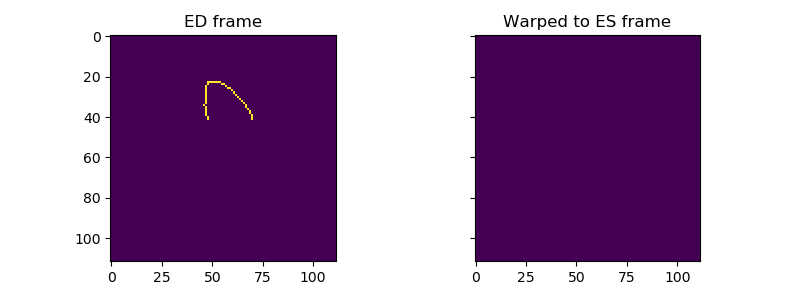

In [43]:
all_strains = get_local_strain_single_video(test_pat_index = 0, 
                                            test_dataset = test_dataset, 
                                            model = model, 
                                            N = 3, 
                                            vis=True)

In [44]:
curr_clip_segmentations.shape

(2, 32, 112, 112)

In [45]:
curr_clip_segmentations.max(), curr_clip_segmentations.min()

(10.422019958496094, -9.938758850097656)

In [46]:
curr_clip_motions.shape

(4, 32, 112, 112)

In [47]:
curr_clip_motions.max(), curr_clip_motions.min()

(0.8517086505889893, -0.7713068127632141)

In [48]:
curr_clip_segmentations[0][0][23][47], curr_clip_segmentations[1][0][23][47]

(0.9654039740562439, -1.0369848012924194)

In [49]:
curr_clip_motions[0][0][23][47]

-0.05518908053636551

In [50]:
I_copy[23][47]

NameError: name 'I_copy' is not defined

In [51]:
ed_raw_seg_out[0][23][47], ed_raw_seg_out[1][23][47]

(0.9654039740562439, -1.0369848012924194)

In [52]:
I_copy[23][48]

NameError: name 'I_copy' is not defined

In [ ]:
ed_raw_seg_out[0][23][48], ed_raw_seg_out[1][23][48]

In [ ]:
np.unique(I_copy), I_copy.shape

In [ ]:
np.unique(ed_raw_seg_out), ed_raw_seg_out.shape

## This proves that the logic to cookie cutter our desired part of the lv boundary in the ed raw seg out is correct. However the motion tracking / motion field warping is having some problem with the values that we are adjusting, I believe.
## This appears to be ok because after one-hot encoding we can visualize it pretty well.

In [41]:
z_, height, width = ed_raw_seg_out.shape
for i in range(height):
    for j in range(width):
        if I_copy[i][j] == 0:
            ed_raw_seg_out[:, i, j] = 0

NameError: name 'I_copy' is not defined

In [42]:
vis_pair(I_copy, one_hot(ed_raw_seg_out))

NameError: name 'I_copy' is not defined

In [ ]:
all_strains = get_local_strain_single_video(test_pat_index = 0, 
                                            test_dataset = test_dataset, 
                                            model = model, 
                                            N = 3, 
                                            vis=True)